# **ALGORITMOS NO SUPERVISADO**

## TRATAMIENTO DE DATOS

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

# ---------------------------------------------------------
# 1. Cargar dataset asegurando MÍNIMO 100 fotos por persona
# ---------------------------------------------------------
# Cambiamos min_faces_per_person a 100.
# Esto filtrará automáticamente a las clases que no llegan a este número
# (Ej. Ariel Sharon y Hugo Chavez quedarán fuera).
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

X_raw = lfw_people.data
y_raw = lfw_people.target
images_raw = lfw_people.images
target_names = lfw_people.target_names

print(f"Personas disponibles con >100 imágenes: {len(target_names)}")
print(f"Nombres: {target_names}")

# ---------------------------------------------------------
# 2. Seleccionar aleatoriamente 100 imágenes EXACTAS por clase
# ---------------------------------------------------------
indices_balanced = []
IMAGENES_POR_CLASE = 100

# Fijamos semilla para que la selección sea reproducible
np.random.seed(42)

for class_idx in range(len(target_names)):
    # Encontrar todos los índices donde aparece la persona 'class_idx'
    indices_person = np.where(y_raw == class_idx)[0]

    # Seleccionar 100 al azar (sin reemplazo para no repetir fotos)
    # Nota: Como ya filtramos en la carga, garantizamos que len(indices_person) >= 100
    selected_indices = np.random.choice(indices_person, IMAGENES_POR_CLASE, replace=False)

    indices_balanced.extend(selected_indices)

# Ordenamos los índices para mantener el orden relativo (opcional)
indices_balanced = np.sort(indices_balanced)

# ---------------------------------------------------------
# 3. Crear los arrays filtrados finales (X, y, images)
# ---------------------------------------------------------
X_filtered = X_raw[indices_balanced]
y_filtered = y_raw[indices_balanced]
images_filtered = images_raw[indices_balanced]

# Actualizar target_names (en este caso son los mismos, pero es buena práctica)
target_names_filtered = target_names

# ---------------------------------------------------------
# 4. Verificación Final
# ---------------------------------------------------------
print("\n--- Dataset Final Balanceado (X_filtered) ---")
print(f"Dimensiones de X_filtered: {X_filtered.shape}")
print(f"Total de Clases: {len(target_names_filtered)}")

print("\nConteo por clase:")
unique, counts = np.unique(y_filtered, return_counts=True)
for i, count in zip(unique, counts):
    print(f"  {target_names_filtered[i]:<20}: {count} imágenes")

Personas disponibles con >100 imágenes: 5
Nombres: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']

--- Dataset Final Balanceado (X_filtered) ---
Dimensiones de X_filtered: (500, 1850)
Total de Clases: 5

Conteo por clase:
  Colin Powell        : 100 imágenes
  Donald Rumsfeld     : 100 imágenes
  George W Bush       : 100 imágenes
  Gerhard Schroeder   : 100 imágenes
  Tony Blair          : 100 imágenes


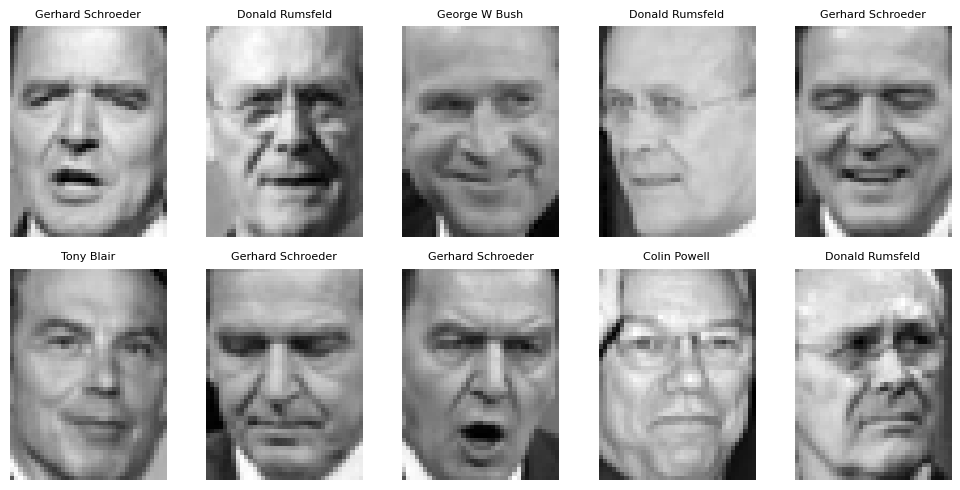

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(images_filtered[i], cmap="gray")
    ax.set_title(target_names_filtered[y_filtered[i]], fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
X_filtered = X_filtered / 255.0

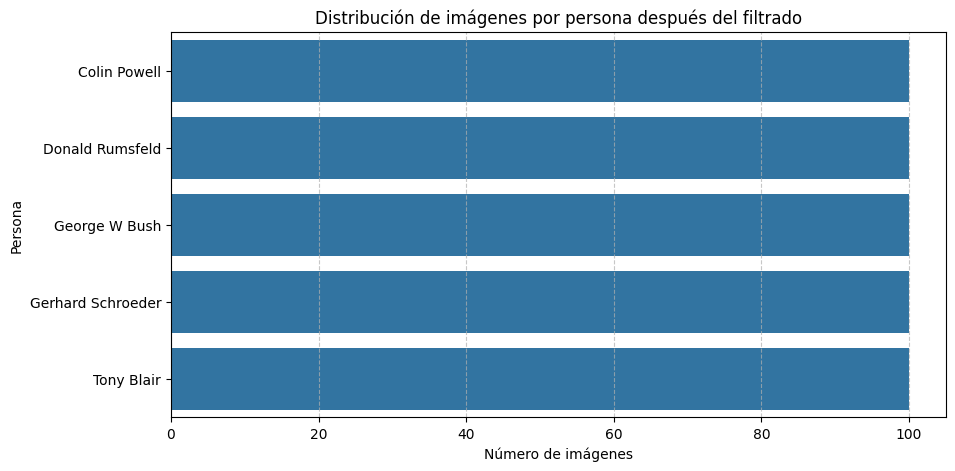

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ===============================================================
# 📊 2. DISTRIBUCIÓN DE IMÁGENES POR PERSONA
# ===============================================================

# 1. Obtenemos los índices únicos y sus conteos
unique, counts = np.unique(y_filtered, return_counts=True)

# 2. CORRECCIÓN: Seleccionamos solo los nombres que corresponden a esos índices únicos.
# Esto asegura que la lista de nombres tenga EXACTAMENTE el mismo largo que la lista de conteos.
names_present = target_names_filtered[unique]

plt.figure(figsize=(10, 5))

# Usamos 'names_present' en lugar de 'target_names_filtered'
sns.barplot(x=counts, y=names_present)

plt.xlabel("Número de imágenes")
plt.ylabel("Persona")
plt.title("Distribución de imágenes por persona después del filtrado")
plt.grid(axis='x', linestyle='--', alpha=0.7) # Agregué una grilla suave para mejor lectura
plt.show()

In [ ]:
X_filtered.shape

(500, 1850)

In [ ]:
clusters = len(np.unique(y_filtered))

# **KMEANS**

In [ ]:
from sklearn.cluster import KMeans

kms = KMeans(n_clusters=5, random_state=42, n_init=10)
kms.fit(X_filtered)

kms_labels = kms.labels_

print(f"Número de clusters encontrados por K-Means: {len(np.unique(kms_labels))}")
print(f"Primeras 10 etiquetas de cluster asignadas por K-Means: {kms_labels[:10]}")

Número de clusters encontrados por K-Means: 5
Primeras 10 etiquetas de cluster asignadas por K-Means: [4 0 1 4 2 4 2 0 4 0]


### Metodo del codo

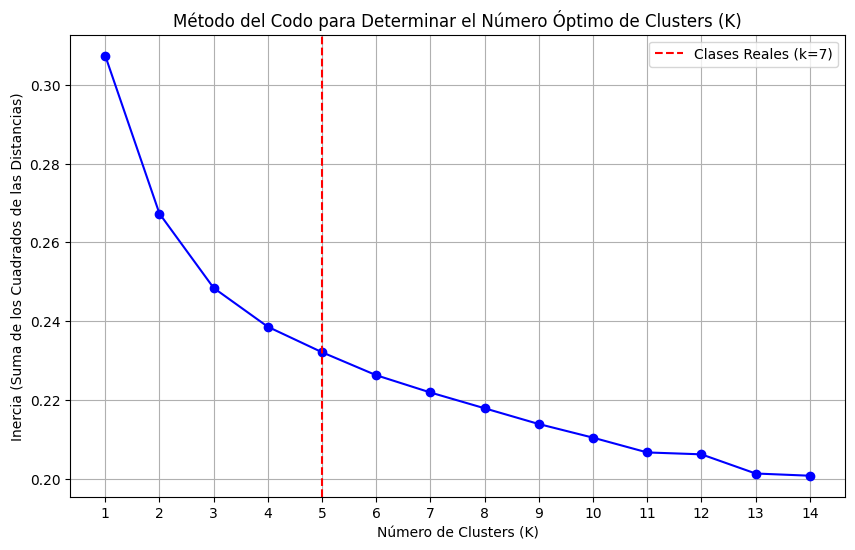

In [ ]:
k_range = range(1, 15)
# Lista para almacenar el valor de la Inercia (suma de cuadrados de las distancias)
inertia = []

# Iterar sobre el rango de k
for k in k_range:
    # Definir el modelo K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Entrenar el modelo
    kmeans.fit(X_filtered)

    # Almacenar la inercia (WSS - Within-Cluster Sum of Squares)
    inertia.append(kmeans.inertia_)

# 3. Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters (K)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (Suma de los Cuadrados de las Distancias)')
plt.grid(True)
plt.xticks(k_range)

# Resaltar el punto donde ya conoces que hay 7 clases (personas)
# Nota: La gráfica te dirá si 7 es el mejor valor según la inercia.
# Si el codo se encuentra cerca de k=7, confirma tu número de clases.
plt.axvline(x=5, color='r', linestyle='--', label='Clases Reales (k=7)')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.stats import mode

def report_cluster_metrics(cluster_labels, true_labels, target_names):
    """
    Calcula TP, TN, FP, FN mapeando cada cluster a su clase mayoritaria.
    Ademas calcula Precision, Recall, F1-Score, Accuracy y muestra la matriz de confusión local.
    """
    # Matriz de confusión inicial (Filas: Verdad, Columnas: Clusters)
    cm = confusion_matrix(true_labels, cluster_labels)

    # Mapeo: ¿Qué clase real representa mejor a cada cluster?
    cluster_to_class_map = {}

    # --- CABECERA ACTUALIZADA CON NUEVAS MÉTRICAS ---
    header = f"{'Cluster':<8} | {'Clase Asignada':<20} | {'TP':<4} | {'FP':<4} | {'FN':<4} | {'TN':<5} | {'Acc':<5} | {'Prec':<5} | {'Rec':<5} | {'F1':<5}"
    print("\n" + header)
    print("-" * len(header))

    unique_clusters = np.unique(cluster_labels)

    for cluster_idx in unique_clusters:
        # Encontrar los índices de datos en este cluster
        mask_cluster = (cluster_labels == cluster_idx)

        # Obtener las etiquetas reales de los datos en este cluster
        labels_in_cluster = true_labels[mask_cluster]

        if len(labels_in_cluster) == 0:
            continue

        # La moda es la clase más frecuente en este cluster
        majority_class_idx = mode(labels_in_cluster, keepdims=True)[0][0]
        assigned_name = target_names[majority_class_idx]
        cluster_to_class_map[cluster_idx] = assigned_name

        # --- CÁLCULOS ORIGINALES (TP, FP, FN, TN) ---
        # TP: Estás en el cluster Y eres de la clase mayoritaria
        TP = np.sum((cluster_labels == cluster_idx) & (true_labels == majority_class_idx))

        # FP: Estás en el cluster PERO NO eres de la clase mayoritaria (Ruido en el cluster)
        FP = np.sum((cluster_labels == cluster_idx) & (true_labels != majority_class_idx))

        # FN: Eres de la clase mayoritaria PERO NO estás en este cluster (Se fueron a otro lado)
        FN = np.sum((cluster_labels != cluster_idx) & (true_labels == majority_class_idx))

        # TN: NO estás en el cluster Y NO eres de la clase (Correctamente rechazado)
        TN = np.sum((cluster_labels != cluster_idx) & (true_labels != majority_class_idx))

        # --- NUEVOS CÁLCULOS (Métricas) ---
        # Accuracy: (TP + TN) / Total
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

        # Precision: TP / (TP + FP)  (¿Qué tan puro es el cluster?)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: TP / (TP + FN) (¿Cuántos de la clase real atrapamos?)
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1-Score: Media armónica de Precision y Recall
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # --- IMPRESIÓN DE FILA CON MÉTRICAS ---
        print(f"{cluster_idx:<8} | {assigned_name[:20]:<20} | {TP:<4} | {FP:<4} | {FN:<4} | {TN:<5} | {accuracy:.2f}  | {precision:.2f}  | {recall:.2f}  | {f1_score:.2f}")

        # --- IMPRESIÓN DE MATRIZ DE CONFUSIÓN DEL CLUSTER ---
        # Formato visual de matriz 2x2 para este cluster específico
        print(f"         > Matriz Confusión Cluster {cluster_idx}: [[TN={TN}, FP={FP}], [FN={FN}, TP={TP}]]")
        print("-" * len(header))
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1_score:.4f}")

    return cluster_to_class_map


  ANÁLISIS 1: K-MEANS SOBRE DATOS CRUDOS

Cluster  | Clase Asignada       | TP   | FP   | FN   | TN    | Acc   | Prec  | Rec   | F1   
--------------------------------------------------------------------------------------------
0        | Gerhard Schroeder    | 9    | 22   | 91   | 378   | 0.77  | 0.29  | 0.09  | 0.14
         > Matriz Confusión Cluster 0: [[TN=378, FP=22], [FN=91, TP=9]]
--------------------------------------------------------------------------------------------
Accuracy: 0.7740
Precision: 0.2903
Recall: 0.0900
F1-Score: 0.1374
1        | Gerhard Schroeder    | 16   | 37   | 84   | 363   | 0.76  | 0.30  | 0.16  | 0.21
         > Matriz Confusión Cluster 1: [[TN=363, FP=37], [FN=84, TP=16]]
--------------------------------------------------------------------------------------------
Accuracy: 0.7580
Precision: 0.3019
Recall: 0.1600
F1-Score: 0.2092
2        | Tony Blair           | 19   | 30   | 81   | 370   | 0.78  | 0.39  | 0.19  | 0.26
         > Matriz Confusión Cl

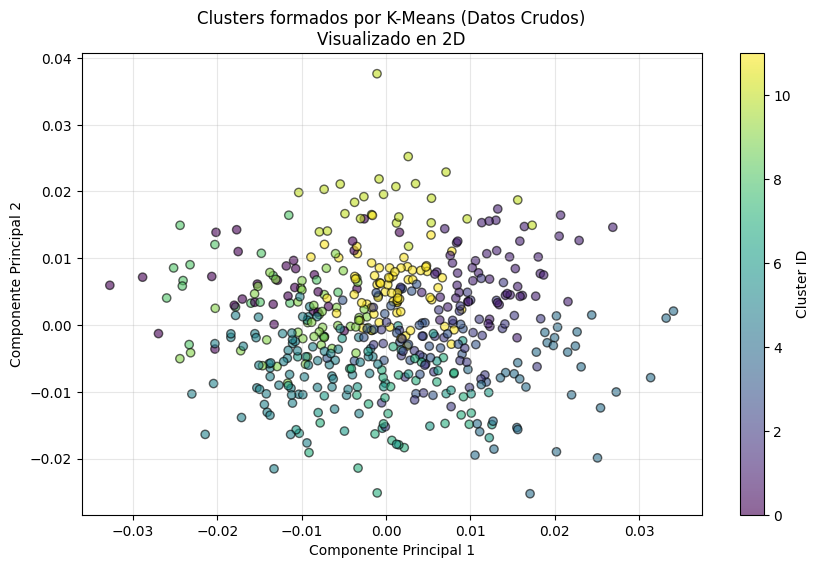

In [ ]:
print("\n" + "="*40)
print("  ANÁLISIS 1: K-MEANS SOBRE DATOS CRUDOS")
print("="*40)

# 1. Entrenar K-Means
kms_raw = KMeans(n_clusters=12, random_state=42, n_init=10)
kms_raw.fit(X_filtered) # Entrenamos con las 1850 características
labels_raw = kms_raw.labels_

# 2. Reporte de TP/TN/FP/FN
_ = report_cluster_metrics(labels_raw, y_filtered, target_names_filtered)

# 3. Visualización de Clusters (Necesitamos PCA solo para poder pintar en 2D)
pca_viz = PCA(n_components=2, random_state=42)
X_viz = pca_viz.fit_transform(X_filtered)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_viz[:, 0], X_viz[:, 1], c=labels_raw, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title('Clusters formados por K-Means (Datos Crudos)\nVisualizado en 2D')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

## **PCA + KMEANS**

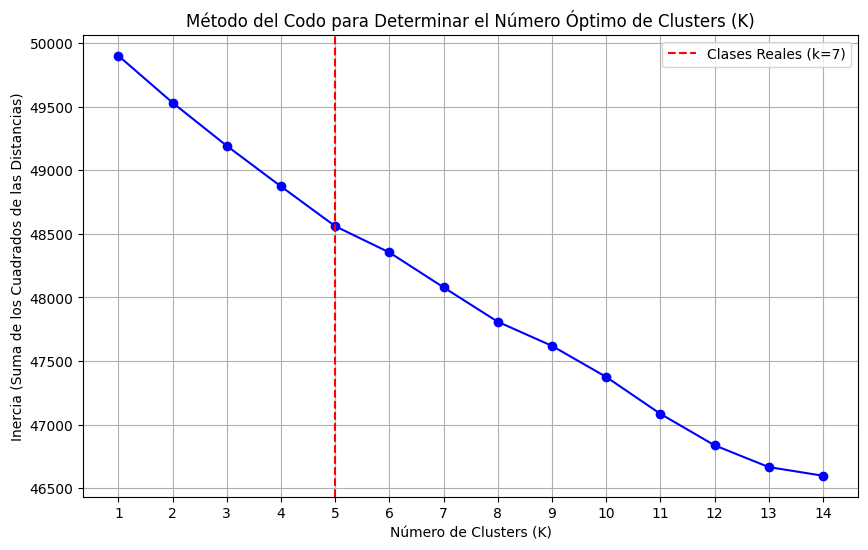

In [ ]:
X_data = X_filtered # Usamos los datos filtrados y vectorizados

# Reducimos a 100 componentes (un valor común para LFW)
n_components = 100
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_data)
X_pca = pca.transform(X_data)


# 2. Realizar la Prueba del Codo

# Rango de clusters a probar (por ejemplo, de k=1 a k=15)
k_range = range(1, 15)
# Lista para almacenar el valor de la Inercia (suma de cuadrados de las distancias)
inertia = []

# Iterar sobre el rango de k
for k in k_range:
    # Definir el modelo K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    # Entrenar el modelo
    kmeans.fit(X_pca)

    # Almacenar la inercia (WSS - Within-Cluster Sum of Squares)
    inertia.append(kmeans.inertia_)

# 3. Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters (K)')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (Suma de los Cuadrados de las Distancias)')
plt.grid(True)
plt.xticks(k_range)

# Resaltar el punto donde ya conoces que hay 7 clases (personas)
# Nota: La gráfica te dirá si 7 es el mejor valor según la inercia.
# Si el codo se encuentra cerca de k=7, confirma tu número de clases.
plt.axvline(x=5, color='r', linestyle='--', label='Clases Reales (k=7)')
plt.legend()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kms = KMeans(n_clusters=5, random_state=42, n_init=10)
kms.fit(X_pca)

kms_labels = kms.labels_

print(f"Número de clusters encontrados por K-Means: {len(np.unique(kms_labels))}")
print(f"Primeras 10 etiquetas de cluster asignadas por K-Means: {kms_labels[:10]}")

Número de clusters encontrados por K-Means: 5
Primeras 10 etiquetas de cluster asignadas por K-Means: [1 1 3 1 3 1 3 1 1 0]



  ANÁLISIS 2: K-MEANS + PCA

Cluster  | Clase Asignada       | TP   | FP   | FN   | TN    | Acc   | Prec  | Rec   | F1   
--------------------------------------------------------------------------------------------
0        | Colin Powell         | 29   | 83   | 71   | 317   | 0.69  | 0.26  | 0.29  | 0.27
         > Matriz Confusión Cluster 0: [[TN=317, FP=83], [FN=71, TP=29]]
--------------------------------------------------------------------------------------------
Accuracy: 0.6920
Precision: 0.2589
Recall: 0.2900
F1-Score: 0.2736
1        | Tony Blair           | 30   | 66   | 70   | 334   | 0.73  | 0.31  | 0.30  | 0.31
         > Matriz Confusión Cluster 1: [[TN=334, FP=66], [FN=70, TP=30]]
--------------------------------------------------------------------------------------------
Accuracy: 0.7280
Precision: 0.3125
Recall: 0.3000
F1-Score: 0.3061
2        | Donald Rumsfeld      | 28   | 88   | 72   | 312   | 0.68  | 0.24  | 0.28  | 0.26
         > Matriz Confusión Cluster 2: [[T

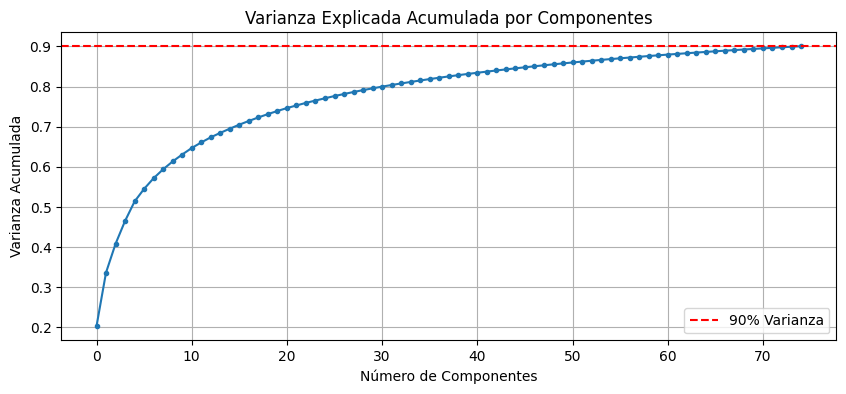

Visualizando Eigenfaces (Los componentes principales como imágenes)...


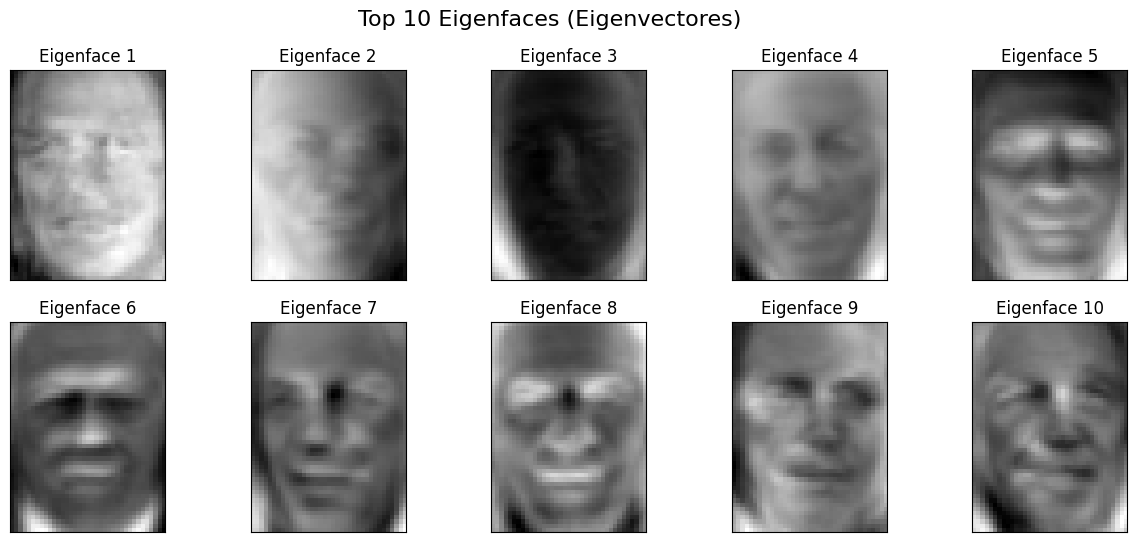

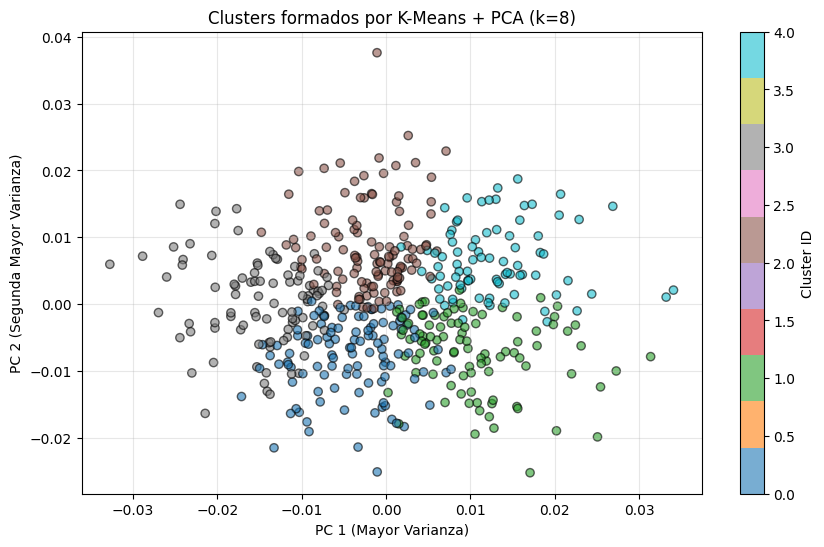

In [ ]:
print("\n" + "="*40)
print("  ANÁLISIS 2: K-MEANS + PCA")
print("="*40)

# 1. Aplicar PCA
n_components = 75
pca = PCA(n_components=n_components).fit(X_filtered)
X_pca = pca.transform(X_filtered)

# 2. Entrenar K-Means sobre datos reducidos
# Usamos 8 clusters como pediste en tu código
kms_pca = KMeans(n_clusters=5, random_state=42, n_init=10)
kms_pca.fit(X_pca)
labels_pca = kms_pca.labels_

# 3. Reporte de TP/TN/FP/FN
_ = report_cluster_metrics(labels_pca, y_filtered, target_names_filtered)


# --- VISUALIZACIONES ESPECÍFICAS DE PCA ---

# A. Visualización de la Varianza (Eigenvalues)
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
plt.title('Varianza Explicada Acumulada por Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Varianza') # Referencia
plt.legend()
plt.show()

# B. Visualización de Eigenvectors (Eigenfaces)
# Los componentes principales tienen forma (n_components, n_features)
# Debemos redimensionarlos a la forma de la imagen original (50, 37)
eigenfaces = pca.components_.reshape((n_components, 50, 37))

print("Visualizando Eigenfaces (Los componentes principales como imágenes)...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6),
                         subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
plt.suptitle("Top 10 Eigenfaces (Eigenvectores)", fontsize=16)
plt.show()



# C. Visualización de los Clusters (Usando las 2 primeras componentes del PCA que ya calculamos)
plt.figure(figsize=(10, 6))
# Usamos X_pca[:, 0] y X_pca[:, 1] que son las coordenadas más importantes
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pca, cmap='tab10', alpha=0.6, edgecolor='k')
plt.title(f'Clusters formados por K-Means + PCA (k={8})')
plt.xlabel('PC 1 (Mayor Varianza)')
plt.ylabel('PC 2 (Segunda Mayor Varianza)')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

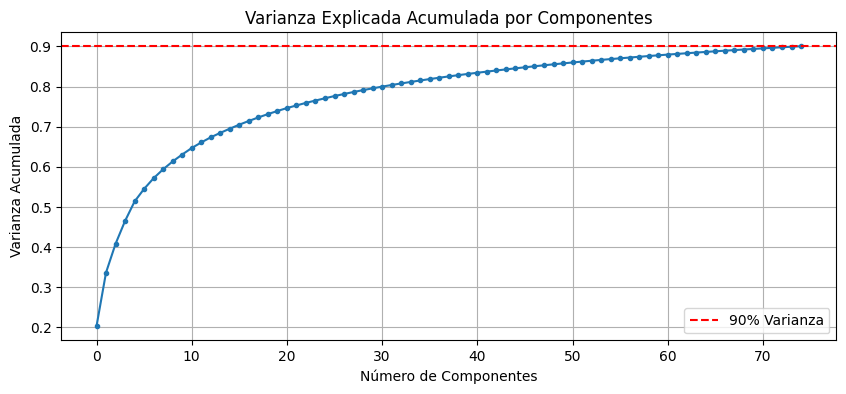

Visualizando Eigenfaces...


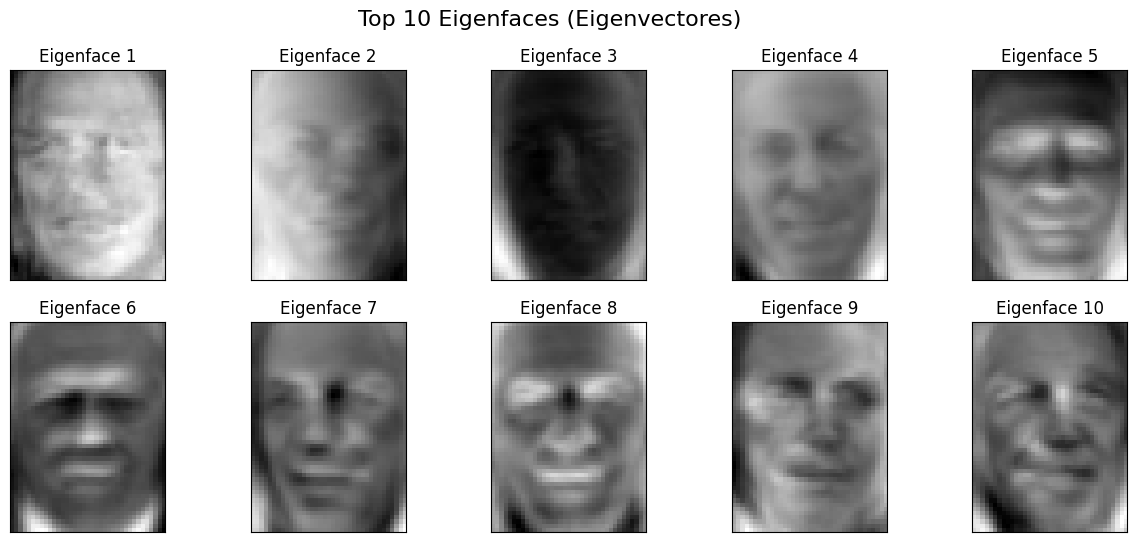

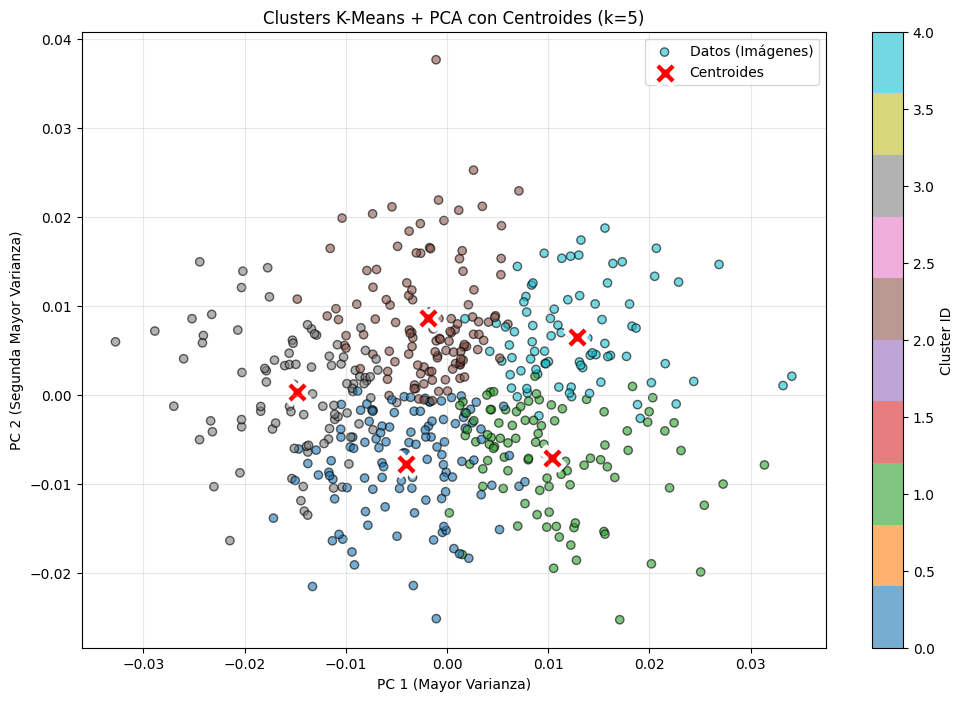

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ... (El código previo de carga y fit se mantiene igual) ...
# Asumiendo que ya ejecutaste las partes 1 y 2 de tu código:
# n_components = 75
# pca = PCA...
# kms_pca = KMeans... etc.

# --- VISUALIZACIONES ESPECÍFICAS DE PCA ---

# A. Visualización de la Varianza (Se mantiene igual)
plt.figure(figsize=(10, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='.')
plt.title('Varianza Explicada Acumulada por Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Varianza')
plt.legend()
plt.show()

# B. Visualización de Eigenfaces (Se mantiene igual)
eigenfaces = pca.components_.reshape((n_components, 50, 37))
print("Visualizando Eigenfaces...")
fig, axes = plt.subplots(2, 5, figsize=(15, 6), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(eigenfaces[i], cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
plt.suptitle("Top 10 Eigenfaces (Eigenvectores)", fontsize=16)
plt.show()

# =============================================================================
# C. Visualización de los Clusters CON CENTROIDES
# =============================================================================
plt.figure(figsize=(12, 8))

# 1. Graficar los puntos (imágenes)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=labels_pca,
                      cmap='tab10',
                      alpha=0.6,
                      edgecolor='k',
                      label='Datos (Imágenes)')

# 2. Obtener y Graficar los Centroides
# Los centroides tienen shape (n_clusters, n_components)
centroids = kms_pca.cluster_centers_

# Graficamos solo las 2 primeras dimensiones de los centroides (PC1 y PC2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='X',      # Forma de cruz
            s=300,           # Tamaño grande
            c='red',         # Color rojo intenso
            edgecolors='white', # Borde blanco para contraste
            linewidth=3,     # Grosor del borde
            label='Centroides') # Etiqueta para la leyenda

# Decoración
plt.title(f'Clusters K-Means + PCA con Centroides (k={5})') # Corregido k a 7
plt.xlabel('PC 1 (Mayor Varianza)')
plt.ylabel('PC 2 (Segunda Mayor Varianza)')
plt.colorbar(scatter, label='Cluster ID')
plt.legend() # Mostrar leyenda para identificar los centroides
plt.grid(True, alpha=0.3)
plt.show()

## **KMEANS + TSNE**

1. Reduciendo ruido inicial con PCA (50 componentes)...
2. Aplicando t-SNE (Reducción a 2 dimensiones)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


3. Aplicando K-Means sobre el resultado de t-SNE...

--- MÉTRICAS POR CLUSTER (Basado en K-Means sobre t-SNE) ---

Cluster  | Clase Asignada       | TP   | FP   | FN   | TN    | Acc   | Prec  | Rec   | F1   
--------------------------------------------------------------------------------------------
0        | Colin Powell         | 42   | 72   | 58   | 328   | 0.74  | 0.37  | 0.42  | 0.39
         > Matriz Confusión Cluster 0: [[TN=328, FP=72], [FN=58, TP=42]]
--------------------------------------------------------------------------------------------
Accuracy: 0.7400
Precision: 0.3684
Recall: 0.4200
F1-Score: 0.3925
1        | George W Bush        | 50   | 65   | 50   | 335   | 0.77  | 0.43  | 0.50  | 0.47
         > Matriz Confusión Cluster 1: [[TN=335, FP=65], [FN=50, TP=50]]
--------------------------------------------------------------------------------------------
Accuracy: 0.7700
Precision: 0.4348
Recall: 0.5000
F1-Score: 0.4651
2        | Gerhard Schroeder    | 27   | 65   | 7

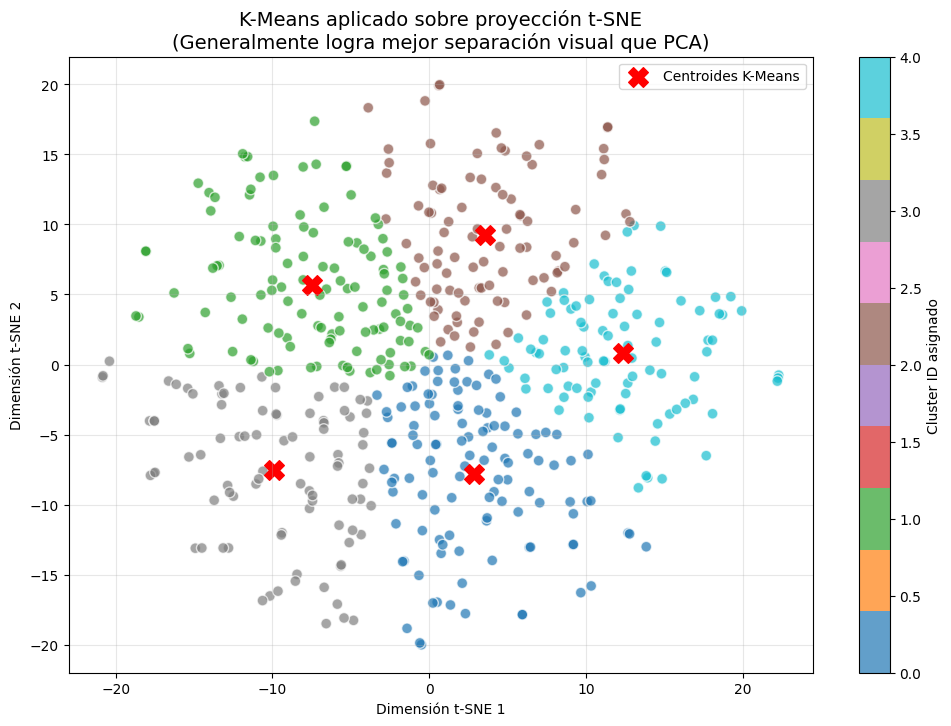

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import mode

# --- 1. Función de Métricas (ACTUALIZADA con Precision, Recall, F1) ---
def report_cluster_metrics(cluster_labels, true_labels, target_names):

    # Cabecera extendida
    header = f"{'Cluster':<8} | {'Clase Asignada':<20} | {'TP':<4} | {'FP':<4} | {'FN':<4} | {'TN':<5} | {'Acc':<5} | {'Prec':<5} | {'Rec':<5} | {'F1':<5}"
    print("\n" + header)
    print("-" * len(header))

    unique_clusters = np.unique(cluster_labels)

    for cluster_idx in unique_clusters:
        mask_cluster = (cluster_labels == cluster_idx)
        labels_in_cluster = true_labels[mask_cluster]

        if len(labels_in_cluster) == 0:
            continue

        # Votación por mayoría
        majority_class_idx = mode(labels_in_cluster, keepdims=True)[0][0]
        assigned_name = target_names[majority_class_idx]

        # --- CÁLCULOS BÁSICOS ---
        # TP: Estás en el cluster Y eres de la clase mayoritaria
        TP = np.sum((cluster_labels == cluster_idx) & (true_labels == majority_class_idx))

        # FP: Estás en el cluster PERO NO eres de la clase mayoritaria
        FP = np.sum((cluster_labels == cluster_idx) & (true_labels != majority_class_idx))

        # FN: Eres de la clase mayoritaria PERO NO estás en este cluster
        FN = np.sum((cluster_labels != cluster_idx) & (true_labels == majority_class_idx))

        # TN: NO estás en el cluster Y NO eres de la clase
        TN = np.sum((cluster_labels != cluster_idx) & (true_labels != majority_class_idx))

        # --- CÁLCULOS DE MÉTRICAS AVANZADAS ---
        # Accuracy: (TP + TN) / Total
        total = TP + TN + FP + FN
        accuracy = (TP + TN) / total if total > 0 else 0

        # Precision (Pureza): TP / (TP + FP)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall (Sensibilidad): TP / (TP + FN)
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1-Score: Media armónica
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Imprimir fila de datos
        print(f"{cluster_idx:<8} | {assigned_name[:20]:<20} | {TP:<4} | {FP:<4} | {FN:<4} | {TN:<5} | {accuracy:.2f}  | {precision:.2f}  | {recall:.2f}  | {f1_score:.2f}")

        # Imprimir Matriz de Confusión Local
        print(f"         > Matriz Confusión Cluster {cluster_idx}: [[TN={TN}, FP={FP}], [FN={FN}, TP={TP}]]")
        print("-" * len(header))
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1_score:.4f}")


# ---------------------------------------------------------
# 2. PROCESAMIENTO: PCA Previo -> t-SNE -> K-Means
# ---------------------------------------------------------

print("1. Reduciendo ruido inicial con PCA (50 componentes)...")
# Recomendado: Primero PCA para bajar a 30-50 dimensiones antes de t-SNE
pca_pre = PCA(n_components=50, random_state=42, whiten=True)
X_pca_50 = pca_pre.fit_transform(X_filtered)

print("2. Aplicando t-SNE (Reducción a 2 dimensiones)...")
# t-SNE es pesado, perplexity=30 es estándar.
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca_50)

print("3. Aplicando K-Means sobre el resultado de t-SNE...")
# K-Means buscará grupos en el mapa 2D generado por t-SNE
# Nota: Si tienes 5 clases balanceadas, lo ideal es n_clusters=5, pero dejé 8 como pediste
kms_tsne = KMeans(n_clusters=5, random_state=42, n_init=10)
kms_tsne.fit(X_tsne)
labels_tsne = kms_tsne.labels_

# ---------------------------------------------------------
# 3. REPORTE DE RESULTADOS
# ---------------------------------------------------------

# A. Tabla de Métricas Completas
print("\n--- MÉTRICAS POR CLUSTER (Basado en K-Means sobre t-SNE) ---")
report_cluster_metrics(labels_tsne, y_filtered, target_names_filtered)

# B. Visualización
plt.figure(figsize=(12, 8))

# Graficamos los puntos t-SNE
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                      c=labels_tsne,
                      cmap='tab10',
                      s=60,
                      alpha=0.7,
                      edgecolor='white')

# Añadir centroides (K-Means calculó centroides en el espacio t-SNE)
centers = kms_tsne.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroides K-Means')

plt.title('K-Means aplicado sobre proyección t-SNE\n(Generalmente logra mejor separación visual que PCA)', fontsize=14)
plt.xlabel('Dimensión t-SNE 1')
plt.ylabel('Dimensión t-SNE 2')
plt.colorbar(scatter, label='Cluster ID asignado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# **DBSCAN**

In [ ]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

# ---------------------------------------------------------
# 1. Cargar dataset asegurando MÍNIMO 100 fotos por persona
# ---------------------------------------------------------
# Cambiamos min_faces_per_person a 100.
# Esto filtrará automáticamente a las clases que no llegan a este número
# (Ej. Ariel Sharon y Hugo Chavez quedarán fuera).
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

X_raw = lfw_people.data
y_raw = lfw_people.target
images_raw = lfw_people.images
target_names = lfw_people.target_names

print(f"Personas disponibles con >100 imágenes: {len(target_names)}")
print(f"Nombres: {target_names}")

# ---------------------------------------------------------
# 2. Seleccionar aleatoriamente 100 imágenes EXACTAS por clase
# ---------------------------------------------------------
indices_balanced = []
IMAGENES_POR_CLASE = 100

# Fijamos semilla para que la selección sea reproducible
np.random.seed(42)

for class_idx in range(len(target_names)):
    # Encontrar todos los índices donde aparece la persona 'class_idx'
    indices_person = np.where(y_raw == class_idx)[0]

    # Seleccionar 100 al azar (sin reemplazo para no repetir fotos)
    # Nota: Como ya filtramos en la carga, garantizamos que len(indices_person) >= 100
    selected_indices = np.random.choice(indices_person, IMAGENES_POR_CLASE, replace=False)

    indices_balanced.extend(selected_indices)

# Ordenamos los índices para mantener el orden relativo (opcional)
indices_balanced = np.sort(indices_balanced)

# ---------------------------------------------------------
# 3. Crear los arrays filtrados finales (X, y, images)
# ---------------------------------------------------------
X_filtered = X_raw[indices_balanced]
y_filtered = y_raw[indices_balanced]
images_filtered = images_raw[indices_balanced]

# Actualizar target_names (en este caso son los mismos, pero es buena práctica)
target_names_filtered = target_names

# ---------------------------------------------------------
# 4. Verificación Final
# ---------------------------------------------------------
print("\n--- Dataset Final Balanceado (X_filtered) ---")
print(f"Dimensiones de X_filtered: {X_filtered.shape}")
print(f"Total de Clases: {len(target_names_filtered)}")

print("\nConteo por clase:")
unique, counts = np.unique(y_filtered, return_counts=True)
for i, count in zip(unique, counts):
    print(f"  {target_names_filtered[i]:<20}: {count} imágenes")

Personas disponibles con >100 imágenes: 5
Nombres: ['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']

--- Dataset Final Balanceado (X_filtered) ---
Dimensiones de X_filtered: (500, 1850)
Total de Clases: 5

Conteo por clase:
  Colin Powell        : 100 imágenes
  Donald Rumsfeld     : 100 imágenes
  George W Bush       : 100 imágenes
  Gerhard Schroeder   : 100 imágenes
  Tony Blair          : 100 imágenes


In [ ]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=5, min_samples=5)
dbs.fit(X_filtered)

dbs_labels = dbs.labels_

n_clusters_dbscan = len(np.unique(dbs_labels))
n_noise = np.sum(dbs_labels == -1)

print(f"Número de clusters encontrados por DBSCAN: {n_clusters_dbscan}")
print(f"Número de puntos clasificados como ruido: {n_noise}")
print(f"Primeras 10 etiquetas de cluster asignadas por DBSCAN: {dbs_labels[:10]}")

Número de clusters encontrados por DBSCAN: 1
Número de puntos clasificados como ruido: 0
Primeras 10 etiquetas de cluster asignadas por DBSCAN: [0 0 0 0 0 0 0 0 0 0]


## **DBSCAN + PCA**

In [ ]:
X_data = X_filtered # Usamos los datos filtrados y vectorizados

# Reducimos a 100 componentes (un valor común para LFW)
n_components = 100
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_data)
X_pca = pca.transform(X_data)

In [ ]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=12, min_samples=5)
dbs.fit(X_pca)

dbs_labels = dbs.labels_

n_clusters_dbscan = len(np.unique(dbs_labels[dbs_labels != -1]))
n_noise = np.sum(dbs_labels == -1)

print(f"Número de clusters encontrados por DBSCAN: {n_clusters_dbscan}")
print(f"Número de puntos clasificados como ruido: {n_noise}")
print(f"Primeras 10 etiquetas de cluster asignadas por DBSCAN: {dbs_labels[:10]}")

Número de clusters encontrados por DBSCAN: 1
Número de puntos clasificados como ruido: 75
Primeras 10 etiquetas de cluster asignadas por DBSCAN: [-1  0  0  0  0  0  0 -1 -1  0]


In [ ]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps=12, min_samples=5)
dbs.fit(X_filtered)

dbs_labels = dbs.labels_

n_clusters_dbscan = len(np.unique(dbs_labels))
n_noise = np.sum(dbs_labels == -1)

print(f"Número de clusters encontrados por DBSCAN: {n_clusters_dbscan}")
print(f"Número de puntos clasificados como ruido: {n_noise}")
print(f"Primeras 10 etiquetas de cluster asignadas por DBSCAN: {dbs_labels[:10]}")

Número de clusters encontrados por DBSCAN: 1
Número de puntos clasificados como ruido: 0
Primeras 10 etiquetas de cluster asignadas por DBSCAN: [0 0 0 0 0 0 0 0 0 0]


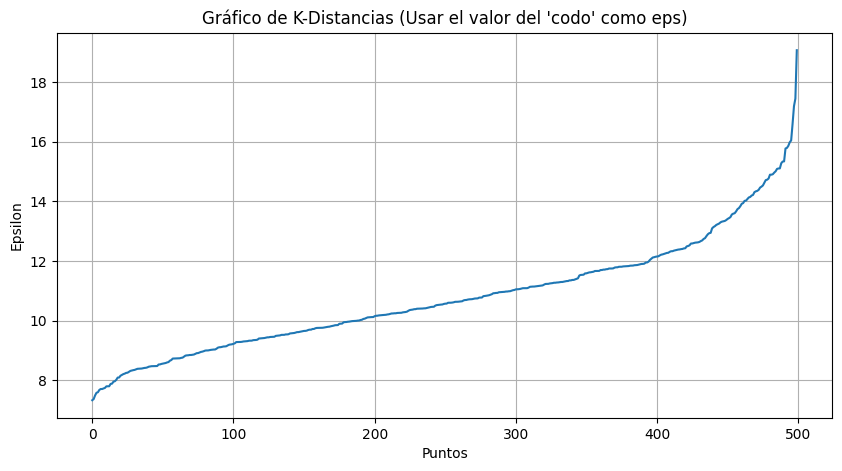

Clusters encontrados: 1
Imágenes clasificadas como Ruido: 25


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# 1. APLICAR PCA (Crucial para que DBSCAN 'vea' las distancias)
# Reducimos de 1850 píxeles a ~80 características principales
pca = PCA(n_components=100, svd_solver='randomized', whiten=True, random_state=42)
X_pca = pca.fit_transform(X_filtered)

# 2. ENCONTRAR EL EPS ÓPTIMO (Método del Codo)
# Calculamos la distancia a los vecinos más cercanos en el espacio reducido
vecinos = NearestNeighbors(n_neighbors=5)
vecinos_fit = vecinos.fit(X_pca)
distancias, indices = vecinos_fit.kneighbors(X_pca)

# Ordenar y graficar distancias para encontrar el 'codo'
distancias = np.sort(distancias[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distancias)
plt.title("Gráfico de K-Distancias (Usar el valor del 'codo' como eps)")
plt.ylabel("Epsilon")
plt.xlabel("Puntos")
plt.grid()
plt.show()

# --- MIRA EL GRÁFICO ANTES DE DEFINIR EL EPS ---
# Supongamos que el codo está en 9.0 (ajusta este valor según tu gráfica)
EPS_OPTIMO = 14

# 3. EJECUTAR DBSCAN
dbscan = DBSCAN(eps=EPS_OPTIMO, min_samples=5)
labels = dbscan.fit_predict(X_pca)

# 4. VER RESULTADOS
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_ruido = list(labels).count(-1)

print(f"Clusters encontrados: {n_clusters}")
print(f"Imágenes clasificadas como Ruido: {n_ruido}")

Ejecutando DBSCAN con eps=14 y min_samples=5...

Resumen:
-> Clusters encontrados: 1
-> Imágenes clasificadas como RUIDO (-1): 25
------------------------------------------------------------------------------------------
Cluster    | Clase Asignada (Mayoría)       | TP    | FP    | FN    | TN   
------------------------------------------------------------------------------------------
0          | Gerhard Schroeder              | 98    | 377   | 2     | 23   
-1         | RUIDO (Sin asignar)            | -     | -     | -     | 25   


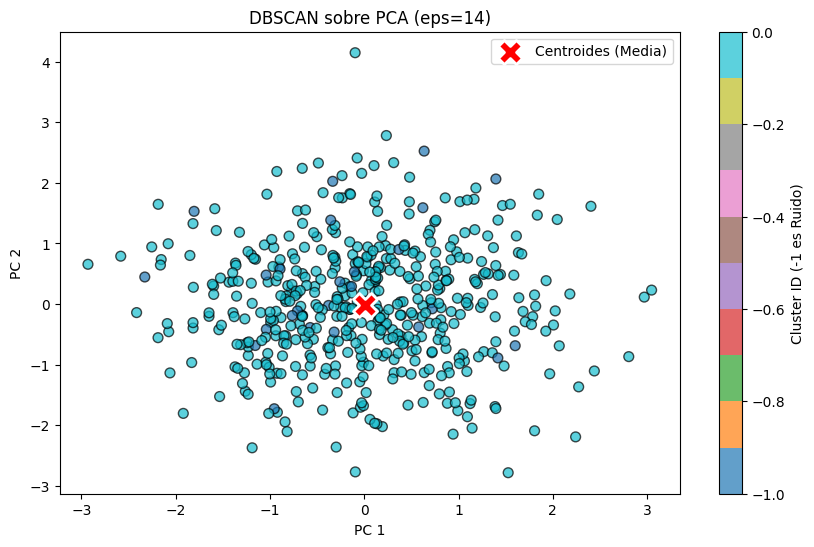

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.stats import mode

# --- CONFIGURACIÓN ---
EPS_SELECCIONADO = 14 # <--- ¡AJUSTA ESTE VALOR SEGÚN TU GRÁFICA!
MIN_SAMPLES = 5

# 1. Entrenar DBSCAN
print(f"Ejecutando DBSCAN con eps={EPS_SELECCIONADO} y min_samples={MIN_SAMPLES}...")
dbscan = DBSCAN(eps=EPS_SELECCIONADO, min_samples=MIN_SAMPLES)
labels_dbscan = dbscan.fit_predict(X_pca)

# 2. Función de reporte detallado
def report_dbscan_metrics(cluster_labels, true_labels, target_names):
    unique_labels = set(cluster_labels)
    n_clusters = len(unique_labels) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    print(f"\nResumen:")
    print(f"-> Clusters encontrados: {n_clusters}")
    print(f"-> Imágenes clasificadas como RUIDO (-1): {n_noise}")
    print("-" * 90)
    print(f"{'Cluster':<10} | {'Clase Asignada (Mayoría)':<30} | {'TP':<5} | {'FP':<5} | {'FN':<5} | {'TN':<5}")
    print("-" * 90)

    for k in unique_labels:
        if k == -1:
            print(f"{k:<10} | {'RUIDO (Sin asignar)':<30} | {'-':<5} | {'-':<5} | {'-':<5} | {n_noise:<5}")
            continue

        # Máscara para ver qué puntos cayeron en este cluster
        mask_cluster = (cluster_labels == k)
        labels_in_cluster = true_labels[mask_cluster]

        # Identificar la clase mayoritaria en este cluster
        majority_idx = mode(labels_in_cluster, keepdims=True)[0][0]
        assigned_name = target_names[majority_idx]

        # --- CÁLCULOS ---
        # TP: Puntos en este cluster que SON de la clase mayoritaria
        TP = np.sum((cluster_labels == k) & (true_labels == majority_idx))

        # FP: Puntos en este cluster que NO SON de la clase mayoritaria (intrusos)
        FP = np.sum((cluster_labels == k) & (true_labels != majority_idx))

        # FN: Puntos que SON de la clase mayoritaria pero NO cayeron en este cluster
        # (incluye los que se fueron a Ruido o a otros clusters erróneos)
        FN = np.sum((cluster_labels != k) & (true_labels == majority_idx))

        # TN: Puntos que NO están en el cluster y NO son de la clase (rechazo correcto)
        TN = np.sum((cluster_labels != k) & (true_labels != majority_idx))

        print(f"{k:<10} | {assigned_name:<30} | {TP:<5} | {FP:<5} | {FN:<5} | {TN:<5}")

# Ejecutar reporte
report_dbscan_metrics(labels_dbscan, y_filtered, target_names_filtered)

# 3. Visualización (Usando las 2 primeras componentes del PCA)
plt.figure(figsize=(10, 6))

# A. Graficar los puntos de datos
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='tab10', s=50, edgecolor='k', alpha=0.7)

# B. Calcular y Graficar Centroides (Agregado solicitado)
# Nota: DBSCAN no da centroides, calculamos la media de los puntos de cada cluster para graficarlos.
unique_labels = set(labels_dbscan)
centroids = []
for k in unique_labels:
    if k != -1: # Ignoramos el ruido para el centroide
        # Calculamos el promedio (centroide) de los puntos que pertenecen al cluster k
        cluster_points = X_pca[labels_dbscan == k]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)

# Convertimos a array para graficar fácilmente
centroids = np.array(centroids)

# Si existen centroides (hay clusters válidos), los dibujamos
if len(centroids) > 0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='X', s=300, c='red',
                edgecolor='white', linewidth=2,
                label='Centroides (Media)')
    plt.legend()

plt.title(f'DBSCAN sobre PCA (eps={EPS_SELECCIONADO})')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(scatter, label='Cluster ID (-1 es Ruido)')
plt.show()

## **DBSCAN + TSNE**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.stats import mode

# Asumimos que X_filtered ya está balanceado (100 fotos por clase)
# X_data = X_filtered

print("1. Aplicando PCA (Reducción de ruido a 50 componentes)...")
pca = PCA(n_components=50, whiten=True, random_state=42)
X_pca = pca.fit_transform(X_filtered)

print("2. Aplicando t-SNE (Generando mapa de islas 2D)...")
# perplexity=30 es estándar, pero con 100 img/clase, 30-50 funciona bien.
tsne = TSNE(n_components=2, perplexity=40, random_state=42, n_iter=1000, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_pca)

print(f"Rango de valores t-SNE: Min {X_tsne.min():.2f}, Max {X_tsne.max():.2f}")

1. Aplicando PCA (Reducción de ruido a 50 componentes)...
2. Aplicando t-SNE (Generando mapa de islas 2D)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Rango de valores t-SNE: Min -14.98, Max 14.70


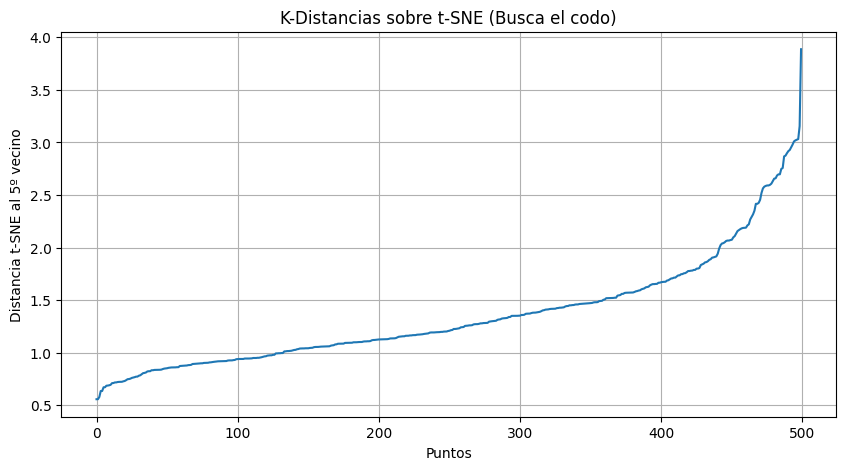

In [ ]:
# Calcular distancia al 5º vecino más cercano en el espacio t-SNE
min_samples = 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_tsne)
distances, indices = neighbors_fit.kneighbors(X_tsne)

# Ordenar distancias
distances = np.sort(distances[:, min_samples-1], axis=0)

# Graficar
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("K-Distancias sobre t-SNE (Busca el codo)")
plt.xlabel("Puntos")
plt.ylabel(f"Distancia t-SNE al {min_samples}º vecino")
plt.grid(True)
plt.show()

## **GRAFICAS**


Ejecutando DBSCAN sobre coordenadas t-SNE (eps=1.25)...

--- RESULTADOS FINALES ---
Clusters detectados: 16
Imágenes Ruido (-1): 154
--------------------------------------------------------------------------------------------
0        | Colin Powell         | 70   | 190  | 30   | 210   | 0.56  | 0.27  | 0.70  | 0.39
         > Matriz Confusión Cluster 0: [[TN=210, FP=190], [FN=30, TP=70]]
--------------------------------------------------------------------------------------------
Accuracy: 0.5600
Precision: 0.2692
Recall: 0.7000
F1-Score: 0.3889
1        | Donald Rumsfeld      | 6    | 0    | 94   | 400   | 0.81  | 1.00  | 0.06  | 0.11
         > Matriz Confusión Cluster 1: [[TN=400, FP=0], [FN=94, TP=6]]
--------------------------------------------------------------------------------------------
Accuracy: 0.8120
Precision: 1.0000
Recall: 0.0600
F1-Score: 0.1132
2        | Gerhard Schroeder    | 3    | 3    | 97   | 397   | 0.80  | 0.50  | 0.03  | 0.06
         > Matriz Confusión Clus

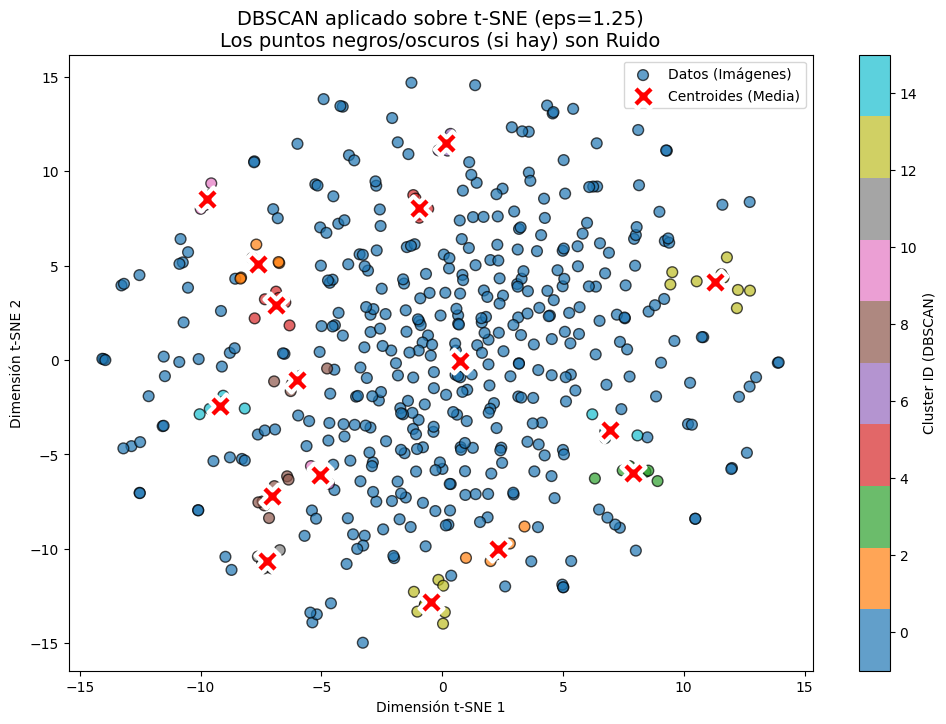

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import mode

# --- AJUSTAR ESTE VALOR SEGÚN LA GRÁFICA ANTERIOR ---
EPS_TSNE = 1.25
MIN_SAMPLES = 5

print(f"\nEjecutando DBSCAN sobre coordenadas t-SNE (eps={EPS_TSNE})...")
dbscan_tsne = DBSCAN(eps=EPS_TSNE, min_samples=MIN_SAMPLES)
labels_tsne_dbscan = dbscan_tsne.fit_predict(X_tsne)

# --- FUNCIÓN DE MÉTRICAS ROBUSTA (ACTUALIZADA) ---
def report_metrics_final(cluster_labels, true_labels, target_names):
    unique_labels = set(cluster_labels)
    # Contar clusters (excluyendo ruido -1)
    real_clusters = [l for l in unique_labels if l != -1]
    n_clusters = len(real_clusters)
    n_noise = list(cluster_labels).count(-1)

    print(f"\n--- RESULTADOS FINALES ---")
    print(f"Clusters detectados: {n_clusters}")
    print(f"Imágenes Ruido (-1): {n_noise}")

    # Cabecera extendida para las nuevas métricas
    header = f"{'Cluster':<8} | {'Clase Asignada':<20} | {'TP':<4} | {'FP':<4} | {'FN':<4} | {'TN':<5} | {'Acc':<5} | {'Prec':<5} | {'Rec':<5} | {'F1':<5}"
    print("-" * len(header))

    for k in unique_labels:
        if k == -1:
            # Fila especial para el ruido
            print(f"{k:<8} | {'RUIDO (Outliers)':<20} | {'-':<4} | {'-':<4} | {'-':<4} | {n_noise:<5} | {'-':<5} | {'-':<5} | {'-':<5} | {'-':<5}")
            continue

        # Filtros booleanos
        mask_cluster = (cluster_labels == k)
        true_labels_in_cluster = true_labels[mask_cluster]

        # Clase mayoritaria
        majority_idx = mode(true_labels_in_cluster, keepdims=True)[0][0]
        class_name = target_names[majority_idx]

        # --- CÁLCULOS BÁSICOS (TP, FP, FN, TN) ---
        # TP: En el cluster Y de la clase correcta
        TP = np.sum((cluster_labels == k) & (true_labels == majority_idx))

        # FP: En el cluster PERO de otra clase (intrusos)
        FP = np.sum((cluster_labels == k) & (true_labels != majority_idx))

        # FN: De la clase correcta PERO NO en este cluster (están en otro cluster o son ruido)
        FN = np.sum((cluster_labels != k) & (true_labels == majority_idx))

        # TN: Ni en el cluster, ni de la clase
        TN = np.sum((cluster_labels != k) & (true_labels != majority_idx))

        # --- CÁLCULOS DE MÉTRICAS AVANZADAS ---
        # Accuracy: (TP + TN) / Total
        total = TP + FP + FN + TN
        accuracy = (TP + TN) / total if total > 0 else 0

        # Precision (Pureza): TP / (TP + FP)
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall (Sensibilidad): TP / (TP + FN)
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1-Score: Media armónica
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Imprimir fila de datos
        print(f"{k:<8} | {class_name[:20]:<20} | {TP:<4} | {FP:<4} | {FN:<4} | {TN:<5} | {accuracy:.2f}  | {precision:.2f}  | {recall:.2f}  | {f1_score:.2f}")

        # Imprimir Matriz de Confusión Local
        print(f"         > Matriz Confusión Cluster {k}: [[TN={TN}, FP={FP}], [FN={FN}, TP={TP}]]")
        print("-" * len(header))
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1_score:.4f}")

# Generar reporte
report_metrics_final(labels_tsne_dbscan, y_filtered, target_names_filtered)

# --- VISUALIZACIÓN FINAL CON CENTROIDES ---
plt.figure(figsize=(12, 8))

# 1. Graficamos los puntos t-SNE coloreados por DBSCAN
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                      c=labels_tsne_dbscan, cmap='tab10',
                      s=60, edgecolor='k', alpha=0.7,
                      label='Datos (Imágenes)')

# 2. Calculamos y graficamos los CENTROIDES manualmente
unique_labels = set(labels_tsne_dbscan)
centroids = []

for k in unique_labels:
    if k != -1:  # Ignoramos el ruido, solo queremos centroides de clusters reales
        # Obtenemos los puntos de este cluster específico
        points_in_cluster = X_tsne[labels_tsne_dbscan == k]
        # Calculamos el promedio (centroide geométrico)
        centroid = points_in_cluster.mean(axis=0)
        centroids.append(centroid)

centroids = np.array(centroids)

# Si encontramos clusters, dibujamos sus centros
if len(centroids) > 0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='X',      # Forma de Cruz
                s=300,           # Tamaño grande
                c='red',         # Color rojo
                edgecolors='white', # Borde blanco para resaltar
                linewidth=3,
                label='Centroides (Media)')
    plt.legend()

plt.title(f'DBSCAN aplicado sobre t-SNE (eps={EPS_TSNE})\nLos puntos negros/oscuros (si hay) son Ruido', fontsize=14)
plt.xlabel('Dimensión t-SNE 1')
plt.ylabel('Dimensión t-SNE 2')
plt.colorbar(scatter, label='Cluster ID (DBSCAN)')
plt.show()